In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This notebook contains code to reproduce the following from Mitra, et al.:

**Supplementary Figures:** 
* Supplementary Figure 4: Distribution of mutation rates by period 
* Supplementary Figure 5: Mutation rate vs. length
* Supplementary Figure 6: Observed mutations at CODIS markers
* Supplementary Figure 7: MUTEA

**Statistics:**
* Number of unique loci analyzed
* Total average mutation rate
* Mutation rates for each period
* Correlation with MUTEA

In [4]:
# Input per-locus info
LOCFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.locus_stats.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats

# Other data paths
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation-rmdup.bed"
CODISFILE = "/storage/mgymrek/workspace/ssc-denovos/metadata/codis_hg38.csv"
NISTFILE = "/storage/ileena/denovos4/annotations/nist_codis_info.txt"
MUTEAFILE = "/storage/mgymrek/ssc-denovos/mutea/MUTEA_MutationRates_hg38_GangSTR.bed"

# Color keys
colors = ['gray','red','gold','blue','green','purple','brown','salmon','magenta','cyan','darkblue']

# Output path info
OUTDIR = "pdfs/"

In [5]:
# Load per-locus mutation info
data = pd.read_csv(LOCFILE, delim_whitespace=True)

# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
data["chrom"] = data["chrom"].apply(GetChrom)
annot = annot[annot["chrom"].apply(lambda x: x not in ["X","chrX","Y","chrY"])]
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(data, annot[["chrom","pos","end","period"]], on=["chrom","pos"])

# Set up CODIS
codis = pd.read_csv(CODISFILE)
codis.columns = ["chrom","pos","Marker"]
codis["chrom"] = codis["chrom"].apply(GetChrom)

nist = pd.read_csv(NISTFILE, sep="\t")
nist["mutrate"] = nist["Total_Mutation_Rate"]
nist = nist[["Marker","mutrate"]]

# Load MUTEA
mutea = pd.read_csv(MUTEAFILE, sep="\t", names=["chrom","pos","end","MUTEA"])
mutea["chrom"] = mutea["chrom"].apply(GetChrom)

In [6]:
print("Number of loci analyzed: %s"%data.shape[0])
print("Total avg mutation rate: %s"%(np.sum(data["mut_unaff"]+data["mut_aff"])*1.0/np.sum(data["all_unaff"]+data["all_aff"])))

Number of loci analyzed: 974004
Total avg mutation rate: 5.130531493301316e-05


# Supplementary Figure 4: Mutation rate by period

/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


   period  mut_aff  mut_unaff  all_unaff      rate    stderr  low      high
0       1   325079      49161  505779480 -4.012340  0.009858  NaN -2.001930
1       2    92425      20701  148198235 -3.854852  0.011818  NaN -1.922353
2       3   116185       3253  186886741 -4.759294  0.004172  NaN -2.377843
3       4   282332       9259  454322232 -4.690800  0.004514  NaN -2.343448
4       5   115465       1643  185547134 -5.052817  0.002976  NaN -2.525120
5       6    28166        356   45271608 -5.104376  0.002804  NaN -2.550974
6       7     6377         25   10235142 -5.612154  0.001563  NaN -2.805399
7       8     3961         37    6349875 -5.234563  0.002414  NaN -2.616236
8       9     1318         15    2107715 -5.147721  0.002668  NaN -2.572705
9      10      775          9    1232628 -5.136590  0.002702  NaN -2.567124


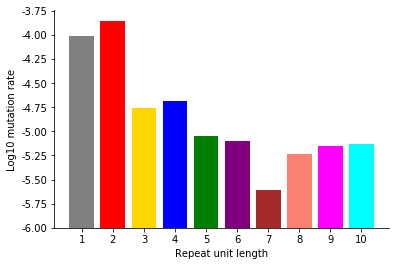

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

offset = 6 # to force bars to be positive

xx = adata[adata["period"]<=10].groupby(["period"], as_index=False).agg({"mut_aff": len, "mut_unaff": np.sum, "all_unaff": np.sum})
xx["rate"] = xx.apply(lambda x: np.log10(x["mut_unaff"]*1.0/x["all_unaff"]), 1)
xx["stderr"] = xx.apply(lambda x: np.sqrt(10**x["rate"]*(1-10**x["rate"])), 1)
xx["low"] = xx.apply(lambda x: np.log10(10**x["rate"]-x["stderr"]), 1)
xx["high"] = xx.apply(lambda x: np.log10(10**x["rate"]+x["stderr"]), 1)
print(xx) # Numbers in each category

ax.bar(xx["period"], xx["rate"]+offset, color=colors)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.set_yticks(np.arange(-6+offset, -3.5+offset, 0.25))
ax.set_yticklabels(["%0.2f"%item for item in np.arange(-6, -3.5, 0.25)])
ax.set_xticks(xx["period"])
ax.set_xticklabels(xx["period"])
ax.set_xlabel("Repeat unit length")
ax.set_ylabel("Log10 mutation rate")
fig.savefig(os.path.join(OUTDIR, "SuppFigure_MutByPeriod.pdf"))

# Supplementary Figure 5: Mutation rate vs. length

/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


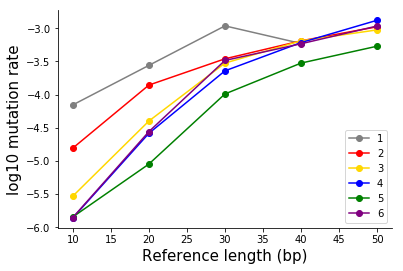

In [8]:
adata["reflen"] = adata["end"]-adata["pos"]+1
lenbins = np.arange(10, 61, 10)

fig = plt.figure()
ax = fig.add_subplot(111)

for period in range(1, 7):
    muts = []
    for i in range(len(lenbins)-1):
        lb = lenbins[i]
        ub = lenbins[i+1]
        x = adata[(adata["period"]==period) & (adata["reflen"]>=lb) & (adata["reflen"]<ub)]
        muts.append(sum(x["mut_unaff"])*1.0/sum(x["all_unaff"]))
    ax.plot(lenbins[:-1], np.log10(muts), color=colors[period-1], label=period, marker="o")
ax.set_xlabel("Reference length (bp)", size=15);
ax.set_ylabel("log10 mutation rate", size=15);
ax.legend(loc="lower right")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');

fig.savefig(os.path.join(OUTDIR, "SuppFigure_MutByLength.pdf"))

# Supplementary Figure 6: Observed mutations at CODIS markers

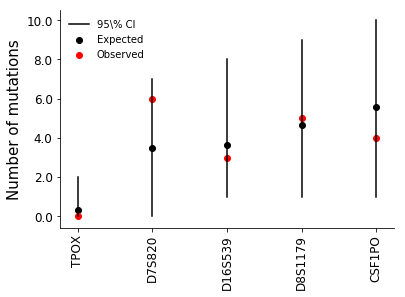

In [9]:
nsim = 1000

cdata = pd.merge(pd.merge(adata, codis, on=["chrom","pos"]), nist, on=["Marker"])
cdata["total_children"] = cdata["all_aff"]+data["all_unaff"]
cdata["total_mutations"] = cdata["mut_aff"]+data["mut_unaff"]
cdata["total_rate"] = cdata["total_mutations"]*1.0/cdata["total_children"]

cdata["codis_exp"] = cdata.apply(lambda x: x["mutrate"]*x["total_children"], 1)
cdata["codis_se"] = cdata.apply(lambda x: np.sqrt(np.var(np.random.binomial(n=x["total_children"], p=x["mutrate"], size=nsim))), 1)

cdata["codis_low"] = cdata.apply(lambda x: np.percentile(np.random.binomial(n=x["total_children"], p=x["mutrate"], size=nsim), 2.5), 1)
cdata["codis_high"] = cdata.apply(lambda x: np.percentile(np.random.binomial(n=x["total_children"], p=x["mutrate"], size=nsim), 97.5), 1)

fig = plt.figure()
ax = fig.add_subplot(111)
cdata = cdata.sort_values("codis_exp")
cdata["order"] = range(cdata.shape[0])
ax.scatter(cdata["order"], cdata["codis_exp"], color="black", label="Expected")
for i in range(cdata.shape[0]):
    x = cdata["order"].values[i]
    low = cdata["codis_low"].values[i]
    high = cdata["codis_high"].values[i]
    obs = cdata["total_mutations"].values[i]
    if i==0:
        ax.scatter([x],[obs], color="red", label="Observed")
        ax.plot([x,x],[low,high], color="black", label="95\% CI")
    else:
        ax.scatter([x],[obs], color="red")
        ax.plot([x,x],[low,high], color="black")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(cdata["order"])
ax.set_xticklabels(cdata["Marker"], rotation=90, size=12);
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.set_ylabel("Number of mutations", size=15)
ax.legend(loc="upper left", frameon=False)

fig.savefig(os.path.join(OUTDIR, "SuppFigure_CODIS.pdf"))

# Supplementary Figure 7: MUTEA

              pos
mut_unaff        
0          513773
1           26180
2            5316
3            3455
(0.2633476515847034, 0.0)
548724


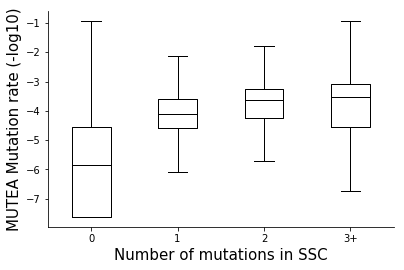

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
boxprops = dict(linestyle='-', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='k')

mdata = pd.merge(adata, mutea, on=["chrom","pos","end"])
mdata["mut_unaff"] = mdata["mut_unaff"].apply(lambda x: [x, 3][x>=3])
bp = mdata.boxplot(by="mut_unaff", column="MUTEA", sym="", ax=ax, 
                                             grid=False, return_type="dict")

ax.set_xlabel("Number of mutations in SSC", size=15)
ax.set_ylabel("MUTEA Mutation rate (-log10)", size=15)
ax.set_xticklabels(["0","1","2","3+"])
ax.set_title("");
plt.suptitle("");

for key in ["whiskers","boxes","medians"]:
    for item in bp["MUTEA"][key]:
        item.set_color("black")

# Print numbers in each category
print(mdata.groupby("mut_unaff").agg({"pos": len}))
print(scipy.stats.pearsonr(mdata["mut_unaff"],
                          mdata["MUTEA"]))
print(mdata.shape[0])

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');

fig.savefig(os.path.join(OUTDIR, "SuppFigure_MUTEA.pdf"))